### Skalowanie & Kodowanie & Strojenie hiperparametrów modeli

In [1]:
# Pakiety
import pandas as pd 
import numpy as np

import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score

np.random.seed(123) 

# Wczytywanie danych
#data = pd.read_csv('/home/elzbieta/WUM_project1/Feature_Engineering/german_credit_data_dataset.csv')
data = pd.read_csv('german_credit_data_dataset.csv')
data = pd.DataFrame(data)

In [2]:
# Kolumny z danymi numerycznymi
num = data.select_dtypes(include=['float64', 'int']).drop('customer_type', axis = 1).columns

# Kolumny z danymi kategorycznymi
cat = data.select_dtypes(include=['object']).columns.tolist()

### 1. Skalowanie danych numerycznych

In [3]:
scaler = StandardScaler()
scaled = data.copy()
scaled[num] = scaler.fit_transform(data[num])

### 2. Podział na zbiory trenigowe i testowe

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(data.drop('customer_type', axis=1), data['customer_type'])
scaled_X_train, scaled_X_test, scaled_Y_train, scaled_Y_test = train_test_split(scaled.drop('customer_type', axis=1), scaled['customer_type'])

### 3. Encoding

#### 3.1. One-Hot Encoding

In [5]:
ohe = ce.OneHotEncoder(data, cols = cat)

# Ramka zakodowana nieskalowana
ohe_train = ohe.fit_transform(X = X_train, y = Y_train)
ohe_test = ohe.transform(X_test)

# Ramka zakodowana, przeskalowana
ohe_scaled_train = ohe.fit_transform(X = scaled_X_train, y = scaled_Y_train)
ohe_scaled_test = ohe.transform(scaled_X_test)

df = pd.DataFrame(ohe_train, Y_train)
#df.to_csv('/home/elzbieta/WUM_project1/Final/dane.csv', index = False)

#### 3.2. Target Encoding

In [6]:
te = ce.TargetEncoder(cols = cat)

# Ramka zakodowana nieskalowana
te_train = te.fit_transform(X = X_train, y = Y_train)
te_test = te.transform(X_test)

# Ramka zakodowana, przeskalowana
te_scaled_train = te.fit_transform(X = scaled_X_train, y = scaled_Y_train)
te_scaled_test = te.transform(scaled_X_test)

#### 3.3. James Stein Encoding

In [7]:
js = ce.JamesSteinEncoder(cols = cat)

# Ramka zakodowana nieskalowana
js_train = js.fit_transform(X = X_train, y = Y_train)
js_test = js.transform(X_test)

# Ramka zakodowana, przeskalowana
js_scaled_train = js.fit_transform(X = scaled_X_train, y = scaled_Y_train)
js_scaled_test = js.transform(scaled_X_test)

#### 3.4. Polynomial Encoding

In [8]:
pe = ce.PolynomialEncoder(cols = cat)

# Ramka zakodowana nieskalowana
pe_train = pe.fit_transform(X = X_train, y = Y_train)
pe_test = pe.transform(X_test)

# Ramka zakodowana, przeskalowana
pe_scaled_train = pe.fit_transform(X = scaled_X_train, y = scaled_Y_train)
pe_scaled_test = pe.transform(scaled_X_test)

### 4. Model

#### 4.1. Random Forest  
Hiperparametry:  

**n_estimators** - ilość drzew składowych (int, domyślnie 100)  
**criterion** - funkcja miary jakości podziału (string, domyślnie gini)  
**max_depth** - maksymalna głębokość drzewa (int, domyślnie None)   
**min_samples_split** - minimalna liczba obserwacji wymagana do podziału węzła wewnętrznego (int/float, domyślnie 2)  
**min_samples_leaf** - minimalna liczba obserwacji wymagana względem liścia (int, domyślnie 1)  
**min_weight_fraction_leaf** - minimalna frakcja wag wymagana względem liścia (domyślnie 0)  
**max_features** - ilość cech branych pod uwagę podczas poszukiwania najlepszego podziału (string). Jeśli “sqrt”, to max_features=sqrt(n_features), jeśli “log2”, to max_features=log2(n_features).  
**max_leaf_nodes** - maksymalna liczba liści (int, domyślnie None)  
**min_impurity_decrease** - węzeł zostanie podzielony, jeśli podział ten spowoduje zmniejszenie miary impurity większe lub równe tej wartości. (float, domyślnie 0)  
**min_impurity_split** - Próg zatrzymania wzrostu drzew. Węzeł rozdzieli się, jeśli jego impurity przekroczy próg, w przeciwnym razie będzie liściem. (float, default 1e-7)  
**bootstrap** - stosowanie bootstrap (bool, domyślnie True)  
**oob_score** - Gdy zestaw treningowy dla bieżącego drzewa jest rysowany przez próbkowanie z wymianą, około jedna trzecia przypadków jest pomijana. Te dane OOB są używane do uzyskania bezstronnego oszacowania błędu klasyfikacji (bool, domyślnie False)  
**oob_score** - liczba powtórzeń instukcji fit, predict, ect.  
**random_state** - kontroluje losowość procedury bootstrap   
**verbose** - int, domyślnie 0 - im wyższa liczba tym więcej informacji uzyskami na temat procedur fit i predict  
**warm_start** - Po ustawieniu wartości True ponownie użyje bieżącego rozwiązania, aby dopasować i dodać więcej estymatorów do zestawu, w przeciwnym razie po prostu zmieni cały nowy las. (bool, domyślnie False)  
**ccp_alpha** - dotyczy przycinania, zostanie wybrane poddrzewo o największym koszcie, który jest mniejszy niż ccp_alpha. Domyślnie 0.0, czyli przycinanie nie jest wykonywane.  
**max_samples** - dotyczy procedury bootstrap (domyślnie None)

In [7]:
# Model
rf_classifier = RandomForestClassifier()

# Hiperparametry
param_grid = {
    'n_estimators' : [50, 100, 200],
    'max_depth' : [None, 4, 8],
    'bootstrap' : [True, False],
    'ccp_alpha' : [0.0, 0.1, 0.2],
    'max_samples' : [None, 0.1, 0.5, 0.9]    
}

In [10]:
# Strojenie modelu dla kodowania One Hot.
rf_grid_search = GridSearchCV(rf_classifier, param_grid = param_grid, cv = 5,n_jobs=-1)
rf_grid_search.fit(te_scaled_train, Y_train)
model1 = rf_grid_search.best_estimator_

KeyboardInterrupt: 

In [10]:
# Z tymn może być problem, mój komputer nie daje rady a strojenie tych parametrów oddzielnie wg mnie nie ma sensu
# Przydałoby się jeszcze zastanowić czy są takie kolumny, z których można by zrezygnować w czasie modelowania

#### 4.2. XGBoost

Hiperparametry:  

-**n_estimators** - ilość drzew składowych (int, domyślnie 100)

-**max_depth** - do uzpełnienia

-**min_child_weight** - do uzpełnienia

-**gamma** - do uzpełnieni

-**subsample** - do uzpełnieni

-**colsample_bytree** - do uzpełnieni

-**learning_rate** - do uzpełnieni

In [9]:
# Funkcja, która znajduje optymalną ilosć drzew (n_estimators parameter) uzywając funkcji cv xgboosta dla
# danej wartosci learning_rate i zmienia wartosc n_parametres odpowiednio

def modelfit(alg, dtrain, predictors, cv_folds = 5, early_stopping_rounds = 50):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = alg.get_params()['n_estimators'],
                      nfold=cv_folds, metrics='auc', early_stopping_rounds = early_stopping_rounds)
    alg.set_params(n_estimators = cvresult.shape[0])
    
    
# Funkcja, która zmierzy nam ilsoc czasu potrzebna na wykonanie danej funkcji

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

IndentationError: unexpected indent (<ipython-input-9-b5fdd2dce520>, line 15)

In [10]:
# siatka parametrów do strojenia

param_grid = {
    'max_depth': range (2, 10, 1),
    'min_child_weight': range(1,10,1),
    'gamma': [i/10.0 for i in range(0,50,5)],
    'subsample': [i/100.0 for i in range(50,100,5)],
    'colsample_bytree': [i/100.0 for i in range(50,100,5)],
    'learning_rate': [0.001,0.01,0.1]
    }

# domyslny classifier

xgb_classifier = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=4)


In [11]:
# one-hot-encoding random
ohe_random_search = RandomizedSearchCV(xgb_classifier, param_distributions = param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = 1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
ohe_random_search.fit(ohe_train, Y_train)
timer(start_time) # ile czasu minelo od start_time
print(ohe_random_search.best_score_)
print(ohe_random_search.best_estimator_)


 Time taken: 0 hours 33 minutes and 46.96 seconds.
0.7735636652185762
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=2,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.6,
              tree_method=None, validate_parameters=False, verbosity=None)


In [18]:
# one-hot-encoding-scaled random
ohe_scaled_random_search = RandomizedSearchCV(xgb_classifier, param_distributions = param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = 1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
ohe_scaled_random_search.fit(ohe_scaled_train, scaled_Y_train)
timer(start_time) # ile czasu minelo od start_time
print(ohe_scaled_random_search.best_score_)
print(ohe_scaled_random_search.best_estimator_)


 Time taken: 0 hours 33 minutes and 9.37 seconds.
0.7986878306878307
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.001, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.85,
              tree_method=None, validate_parameters=False, verbosity=None)


In [13]:
# target random
target_random_search = RandomizedSearchCV(xgb_classifier, param_distributions = param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = 1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
target_random_search.fit(te_train, Y_train)
timer(start_time) # ile czasu minelo od start_time
print(target_random_search.best_score_)
print(target_random_search.best_estimator_)


 Time taken: 0 hours 19 minutes and 9.4 seconds.
0.788942872811228
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.85, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.9,
              tree_method=None, validate_parameters=False, verbosity=None)


In [17]:
# target-scaled random
target_scaled_random_search = RandomizedSearchCV(xgb_classifier, param_distributions = param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = 1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
target_scaled_random_search.fit(te_scaled_train, scaled_Y_train)
timer(start_time) # ile czasu minelo od start_time
print(target_scaled_random_search.best_score_)
print(target_scaled_random_search.best_estimator_)


 Time taken: 0 hours 18 minutes and 59.03 seconds.
0.8060529100529102
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)


In [15]:
janek_df = pd.read_csv('../dane_test')
janek_df.drop(janek_df.columns[0], axis=1)

,checking_account_status,duration,credit_history,purpose,credit_amount,savings,present_employment,installment_rate,personal,other_debtors,present_residence,property,age,other_installment_plans,housing,existing_credits,job,dependents,telephone,foreign_worker
0,1.125828,3.495842,1.180995,1.223810,6.164274,1.185185,1.313253,4.288929,1.260652,1.289436,2.040397,1.303571,1.279717,1.267327,1.249057,0.352238,1.306867,0.000000,1.270000,1.296399
1,1.125828,2.676815,1.297980,1.357143,6.374594,1.337004,1.313253,2.624378,1.260652,1.289436,1.011986,1.213953,1.285684,1.267327,1.249057,0.000000,1.246835,0.103312,1.304444,1.142857
2,1.473684,4.972650,1.297980,1.357143,7.769718,1.337004,1.401460,0.000000,1.333333,1.289436,0.000000,1.213953,1.295844,1.267327,1.249057,0.000000,1.246835,0.000000,1.270000,1.296399
3,1.378641,2.924319,1.297980,1.328358,6.868345,1.337004,1.401460,2.624378,1.333333,1.289436,0.000000,1.213953,1.293496,1.267327,1.387324,0.000000,1.296296,0.000000,1.304444,1.296399
4,1.125828,4.544074,1.297980,1.357143,6.883164,1.185185,1.313253,4.288929,1.260652,1.289436,3.079624,1.213953,1.298080,1.267327,1.249057,0.000000,1.306867,0.000000,1.304444,1.296399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,1.473684,3.919666,1.297980,1.150000,7.427865,1.337004,1.279070,4.288929,1.260652,1.289436,1.011986,1.401786,1.279717,1.267327,1.397436,0.000000,1.296296,0.000000,1.270000,1.296399
746,1.473684,3.919666,1.297980,1.150000,6.842010,1.337004,1.207692,1.174215,1.260652,1.289436,0.000000,1.401786,1.293496,1.267327,1.397436,0.000000,1.296296,0.000000,1.270000,1.296399
747,1.125828,3.789831,1.297980,1.357143,6.234547,1.185185,1.207692,4.288929,1.333333,1.289436,3.079624,1.303571,1.265379,1.267327,1.387324,0.000000,1.306867,0.000000,1.304444,1.296399
748,1.125828,2.924319,1.297980,1.367089,6.372656,1.337004,1.207692,1.174215,1.260652,1.289436,3.079624,1.298039,1.298080,1.267327,1.249057,0.000000,1.306867,0.000000,1.270000,1.296399


In [16]:
# janka random
janek_random_search = RandomizedSearchCV(xgb_classifier, param_distributions = param_grid, n_iter = 1000,
                                   scoring = 'roc_auc', n_jobs = 1, cv = 5, random_state = 1001 )

# Here we go
start_time = timer(None) # aktualna godzina
janek_random_search.fit(janek_df, Y_train)
timer(start_time) # ile czasu minelo od start_time
print(janek_random_search.best_score_)
print(janek_random_search.best_estimator_)


 Time taken: 0 hours 19 minutes and 35.34 seconds.
0.779405550959725
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=4.5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.6,
              tree_method=None, validate_parameters=False, verbosity=None)


### 5. Ewaluacja modeli

In [78]:
def evaluateModel(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_true = Y_test
    print("Accuracy: " + str(accuracy_score(y_true, y_pred, normalize=False)))
    print("Precision: " + str(precision_score(y_true, y_pred, average='macro')))
    print("Recall: " + str(recall_score(y_true, y_pred)))
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba, pos_label=2)
    print("AUC: " + str(metrics.auc(fpr, tpr)))
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()

Accuracy: 187
Precision: 0.7228713724739009
Recall: 0.8988095238095238
AUC: 0.8087253193960512


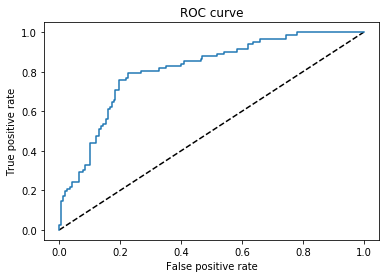

In [79]:
evaluateModel(best_xgb, ohe_train, Y_train,
              ohe_test, Y_test)

Accuracy: 196
Precision: 0.7691271551724138
Recall: 0.9107142857142857
AUC: 0.8172909407665505


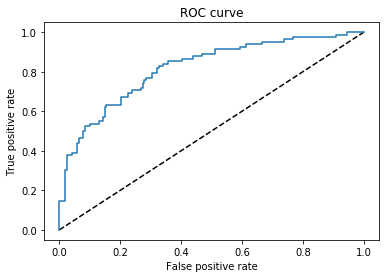

In [80]:
evaluateModel(xgb_classifier, ohe_train, Y_train,
              ohe_test, Y_test)

In [75]:
xgb_classifier

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=True, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [77]:
best_xgb

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=2,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.6,
              tree_method=None, validate_parameters=False, verbosity=None)

6.Feature importance
====

First i will cheack feature importance using feature_importance_  atribute 
using two datasets TargetEncoding_scaled oraz OneHoteEncoding_scaled. 




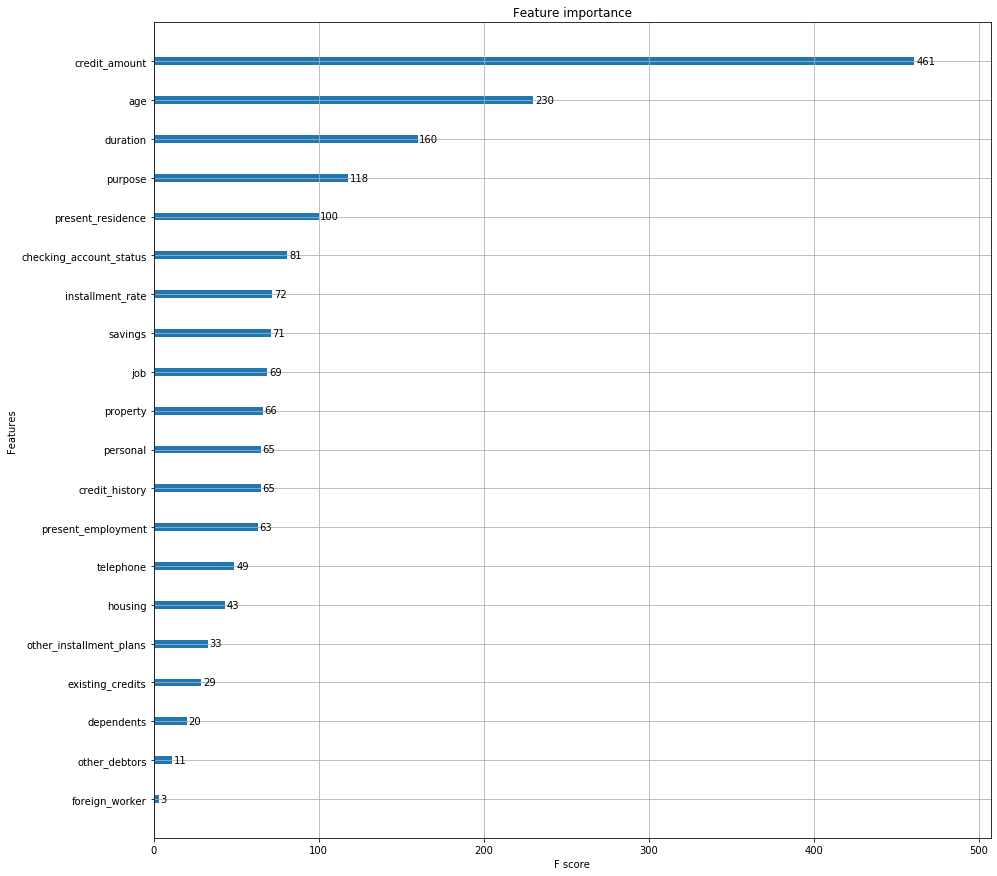

In [24]:
# Feature importance for xgb 
from xgboost import plot_importance
from matplotlib import pyplot
plt.rcParams['figure.figsize'] = [15, 15]

# Targer encoding 
xgb_test = xgb.XGBClassifier()
xgb_test.fit(te_scaled_train,scaled_Y_train)
plot_importance(xgb_test)

Most important feature is credit_ammount is not surpassing. Age and credit_ammount its much more important thene other feturs 

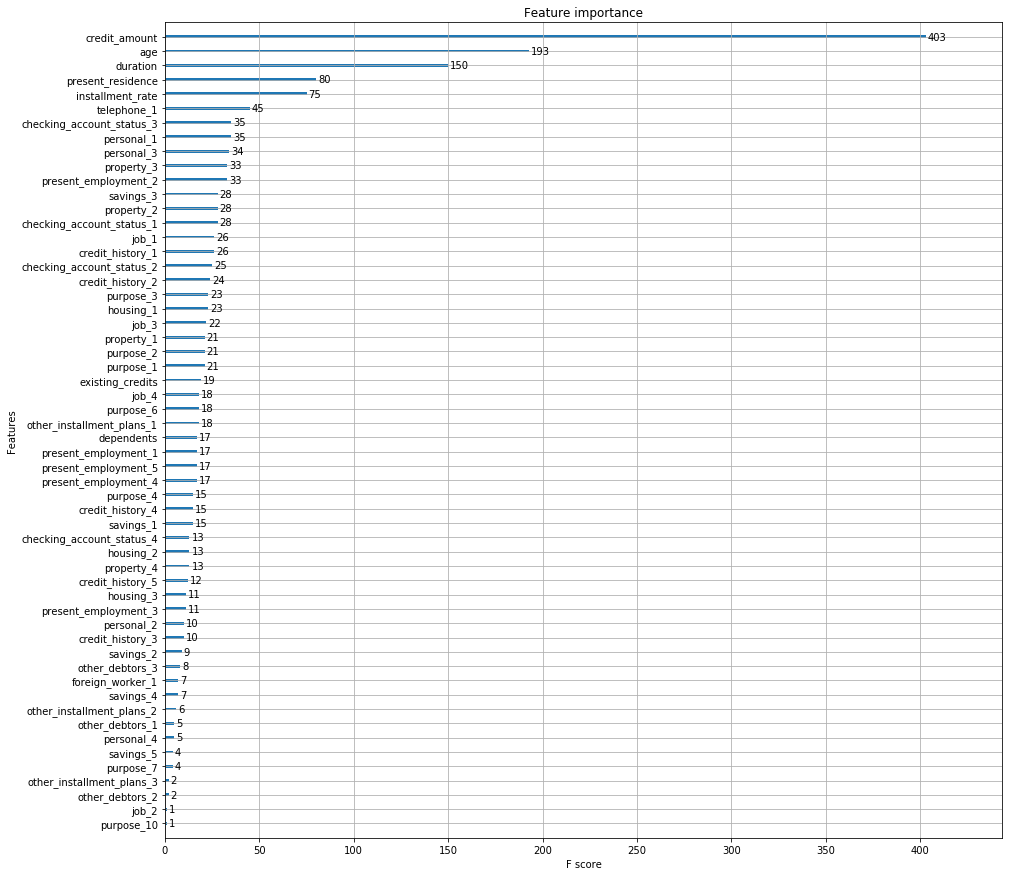

In [81]:
# One hote encoding 
xgb_test_oh = xgb.XGBClassifier()
xgb_test_oh.fit(ohe_scaled_train,scaled_Y_train)
plot_importance(xgb_test_oh)

5 most important featurs are numeric. But most important onehoted featurs alsow achived good score compering to target encoding.

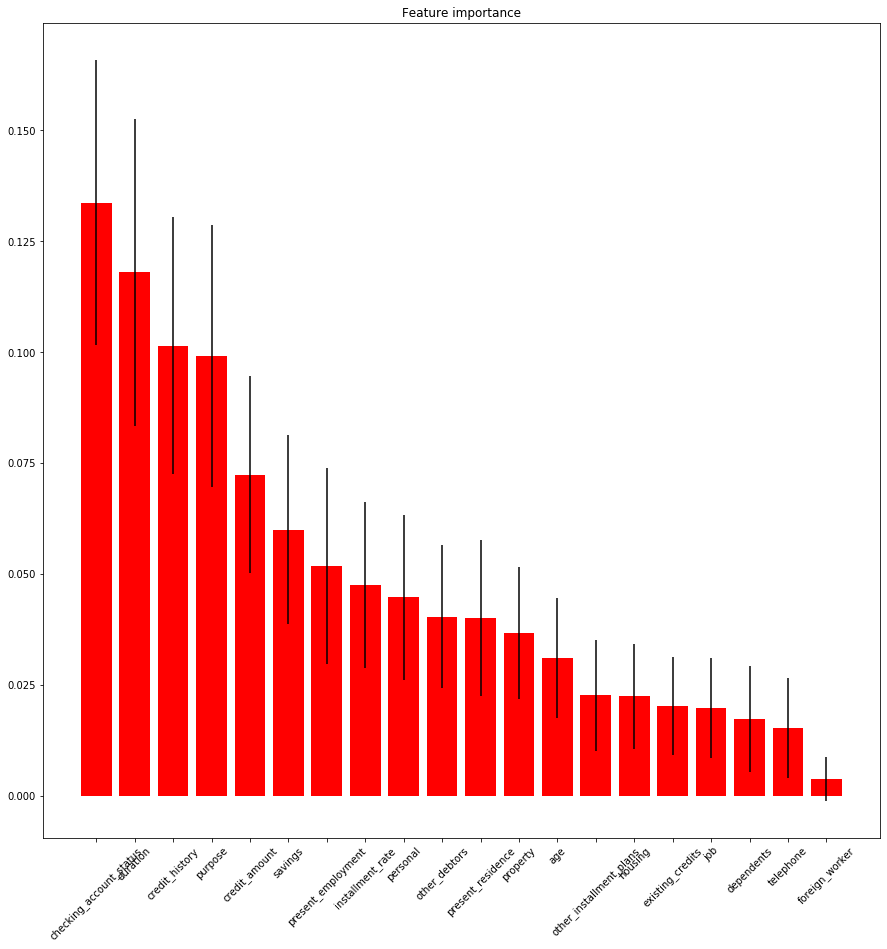

In [82]:
# Feature importance RandomForest

#Target encoding
rf_test = RandomForestClassifier()
rf_test.fit(te_scaled_train,scaled_Y_train)


importances = rf_test.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_test.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


plt.figure()
plt.title("Feature importance")
plt.bar(X_train.columns, importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(rotation=45)
plt.show()

Result complytyly difrent then with XGB this time most important is checking_account_status featurs which was encoded. Numeric featurs is no longer most important.

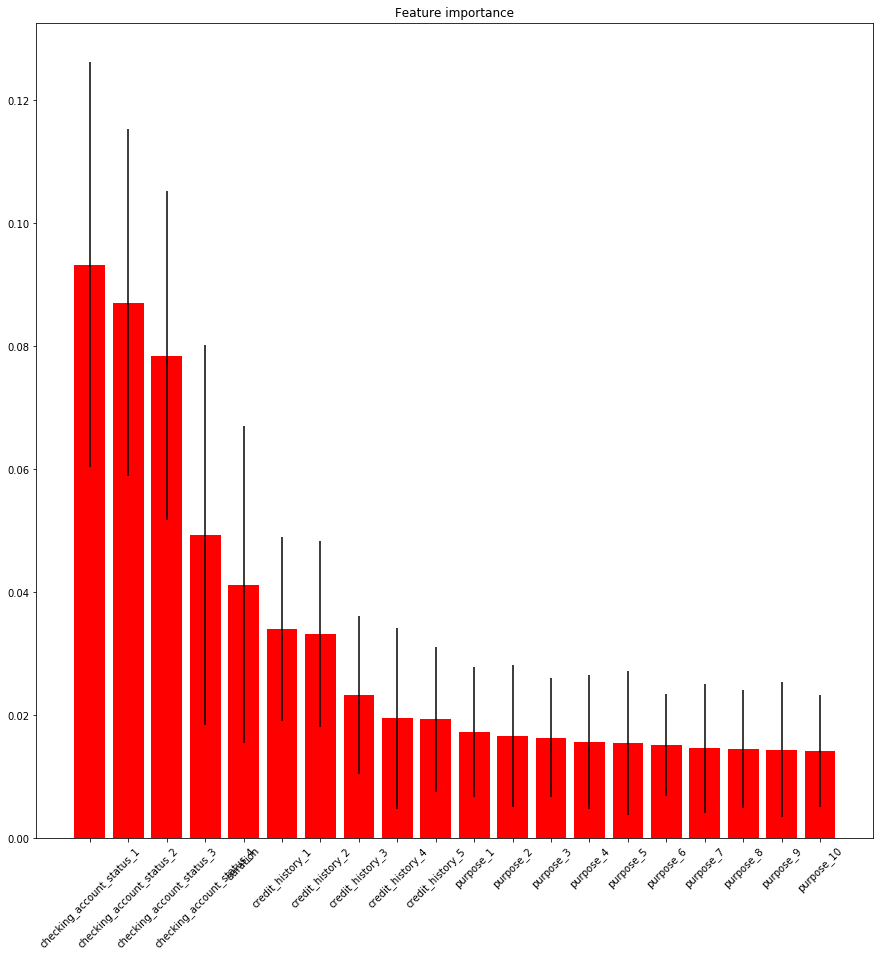

In [83]:
# One -hote encoding 
rf_test = RandomForestClassifier()
rf_test.fit(ohe_scaled_train,scaled_Y_train)

importances = rf_test.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_test.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


plt.figure()
plt.title("Feature importance")
plt.bar(ohe_scaled_train.columns[:20], importances[indices][:20],
       color="r", yerr=std[indices][:20], align="center")
plt.xticks(rotation=45)
plt.show()


Polt for 20 most important featurs. Plot is similar to previous one. 

In [126]:
#Selecting best feturs , i will use boruta algoritm 
# 
# XGB target
from boruta import BorutaPy
def test(X_train,X_test,model):

    
    

    feat_selector = BorutaPy(model, n_estimators='auto',random_state=1)
    feat_selector.fit(X_train.values,scaled_Y_train)


    # feature ranking
    a=feat_selector.support_
    ranking=feat_selector.ranking_
    print(ranking)

    def checking(X_train,X_test,a,ranking,model):
        for i in range(1,max(ranking)+1):
    
            data_test = ranking<=i
            model.fit(X_train.iloc[:,data_test],scaled_Y_train)
            fpr, tpr, thresholds = metrics.roc_curve(scaled_Y_test, model.predict_proba(X_test.iloc[:,data_test])[:,1],pos_label=2)
            print(f"Treschold: {i}  | AUC:  {metrics.auc(fpr,tpr)}")

    # checking for all posible treschold 

    checking(X_train,X_test,a,ranking,model)
    return ranking
test(te_scaled_train,te_scaled_test,xgb.XGBClassifier())
    

[ 1  1  1  3  5  1  4 10  8  1 12  2 12  5 16 10  7 15  9 14]
Treschold: 1  | AUC:  0.7434380378657487
Treschold: 2  | AUC:  0.7317842799770511
Treschold: 3  | AUC:  0.7335771658060815
Treschold: 4  | AUC:  0.7794033275960988
Treschold: 5  | AUC:  0.7769650028686174
Treschold: 6  | AUC:  0.7769650028686174
Treschold: 7  | AUC:  0.783849684452094
Treschold: 8  | AUC:  0.788152610441767
Treschold: 9  | AUC:  0.7899454962707975
Treschold: 10  | AUC:  0.7748852553069422
Treschold: 11  | AUC:  0.7748852553069422
Treschold: 12  | AUC:  0.7773952954675846
Treschold: 13  | AUC:  0.7773952954675846
Treschold: 14  | AUC:  0.7882243258749283
Treschold: 15  | AUC:  0.7800487664945496
Treschold: 16  | AUC:  0.7759609868043603


array([ 1,  1,  1,  3,  5,  1,  4, 10,  8,  1, 12,  2, 12,  5, 16, 10,  7,
       15,  9, 14])

Best results is achived for treachold 9 lets see this features:

In [120]:
te_scaled_train.iloc[:,ranking<=9]
#Worth to notice abbsence of 'age' one of most important column form previuse tests.

,checking_account_status,duration,credit_history,purpose,credit_amount,savings,present_employment,personal,other_debtors,property,other_installment_plans,job,dependents
258,1.107383,-0.489762,1.310777,1.170732,0.191662,1.324675,1.358209,1.333333,1.286558,1.304527,1.270665,1.281780,-0.428290
24,1.107383,-0.904604,1.158371,1.301471,-0.426132,1.178571,1.305882,1.263889,1.286558,1.304527,1.270665,1.281780,-0.428290
804,1.379147,-0.738668,1.310777,1.343195,1.488925,1.178571,1.395833,1.333333,1.286558,1.195238,1.270665,1.312500,-0.428290
709,1.379147,-0.987573,1.310777,1.212560,-0.408765,1.342920,1.305882,1.259804,1.286558,1.195238,1.270665,1.268966,2.334869
197,1.379147,-0.738668,1.310777,1.301471,-0.822400,1.324675,1.358209,1.333333,1.286558,1.304527,1.380000,1.281780,-0.428290
...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,1.107383,-1.236478,1.158371,1.212560,-0.542744,1.342920,1.234973,1.263889,1.286558,1.195238,1.270665,1.281780,-0.428290
228,1.107383,-0.987573,1.310777,1.212560,-0.635608,1.342920,1.215385,1.259804,1.286558,1.304527,1.270665,1.281780,-0.428290
201,1.494737,-0.738668,1.310777,1.343195,-0.745486,1.342920,1.305882,1.263889,1.286558,1.195238,1.270665,1.268966,-0.428290
807,1.107383,-0.738668,1.158371,1.212560,-0.829843,1.178571,1.234973,1.259804,1.286558,1.195238,1.270665,1.281780,-0.428290


In [127]:


# Xgb one hote encoding 
ranking=test(ohe_scaled_train,ohe_scaled_test,xgb.XGBClassifier())



[ 1 42 23  1 12 38 20 29  3  1 15 43 26 30 57  7 16 57 57  9 21  5 38 11
 53 24 45 36  2 25 43 40 36 13 48  6  3 52  8 34 31 13 34 10 32 16 40 34
 45 49 21 50 47 53 18 19 28 27 57 51 57]
Treschold: 1  | AUC:  0.6805077452667815
Treschold: 2  | AUC:  0.671220596672404
Treschold: 3  | AUC:  0.7052854274239817
Treschold: 4  | AUC:  0.7052854274239817
Treschold: 5  | AUC:  0.692914515203672
Treschold: 6  | AUC:  0.7014486517498567
Treschold: 7  | AUC:  0.6986517498565692
Treschold: 8  | AUC:  0.7114170969592656
Treschold: 9  | AUC:  0.7077954675846242
Treschold: 10  | AUC:  0.7174411933448077
Treschold: 11  | AUC:  0.7262263339070566
Treschold: 12  | AUC:  0.761438611589214
Treschold: 13  | AUC:  0.7690404475043029
Treschold: 14  | AUC:  0.7690404475043029
Treschold: 15  | AUC:  0.7671399885255307
Treschold: 16  | AUC:  0.777180149168101
Treschold: 17  | AUC:  0.777180149168101
Treschold: 18  | AUC:  0.7717297762478486
Treschold: 19  | AUC:  0.7744908204245554
Treschold: 20  | AUC:  0.7455

In [129]:
##Best AUC for threschold 33 and its beter then with target encoding 
# Selected featurs 
ohe_scaled_train.columns[ranking<=33]

Index(['checking_account_status_1', 'checking_account_status_3',
       'checking_account_status_4', 'duration', 'credit_history_2',
       'credit_history_3', 'credit_history_4', 'credit_history_5', 'purpose_1',
       'purpose_3', 'purpose_4', 'purpose_6', 'purpose_7', 'purpose_10',
       'credit_amount', 'savings_1', 'savings_3', 'savings_5',
       'present_employment_3', 'present_employment_4', 'personal_2',
       'personal_4', 'other_debtors_1', 'other_debtors_3', 'property_1',
       'property_2', 'property_4', 'age', 'other_installment_plans_1',
       'housing_3', 'job_3', 'job_4', 'dependents', 'telephone_1'],
      dtype='object')

Warth to see somtimes only part of column crated by encoder for some features are selected.

In [134]:
# Random Forest target encoding 
ranking_te=test(te_scaled_train,te_scaled_test,RandomForestClassifier())
# Best for th 14 but veary similar to taing all columns 
te_scaled_train.head().iloc[:,ranking_te<=14]

[ 1  1  3  4  1  5  7  8 10 16  9  6  2 13 12 14 10 17 15 18]
Treschold: 1  | AUC:  0.6720094664371772
Treschold: 2  | AUC:  0.7186603557085485
Treschold: 3  | AUC:  0.7390275387263339
Treschold: 4  | AUC:  0.7417527251864602
Treschold: 5  | AUC:  0.7608290304073437
Treschold: 6  | AUC:  0.7638769363166953
Treschold: 7  | AUC:  0.7774311531841652
Treschold: 8  | AUC:  0.7574584050487665
Treschold: 9  | AUC:  0.743868330464716
Treschold: 10  | AUC:  0.7529403327596099
Treschold: 11  | AUC:  0.764450659781985
Treschold: 12  | AUC:  0.7801204819277108
Treschold: 13  | AUC:  0.7820926563396443
Treschold: 14  | AUC:  0.7868975903614458
Treschold: 15  | AUC:  0.7655622489959839
Treschold: 16  | AUC:  0.7820926563396444
Treschold: 17  | AUC:  0.7870410212277682
Treschold: 18  | AUC:  0.7860370051635113


,checking_account_status,duration,credit_history,purpose,credit_amount,savings,present_employment,installment_rate,personal,present_residence,property,age,other_installment_plans,housing,existing_credits,job
258,1.107383,-0.489762,1.310777,1.170732,0.191662,1.324675,1.358209,-1.764514,1.333333,1.046987,1.304527,-1.103451,1.270665,1.250460,-0.704926,1.281780
24,1.107383,-0.904604,1.158371,1.301471,-0.426132,1.178571,1.305882,-0.870183,1.263889,-1.672459,1.304527,-0.839594,1.270665,1.250460,1.027079,1.281780
804,1.379147,-0.738668,1.310777,1.343195,1.488925,1.178571,1.395833,-1.764514,1.333333,-0.765977,1.195238,-1.015499,1.270665,1.377953,-0.704926,1.312500
709,1.379147,-0.987573,1.310777,1.212560,-0.408765,1.342920,1.305882,-0.870183,1.259804,-0.765977,1.195238,0.127883,1.270665,1.250460,-0.704926,1.268966
197,1.379147,-0.738668,1.310777,1.301471,-0.822400,1.324675,1.358209,0.918477,1.333333,1.046987,1.304527,-0.751642,1.380000,1.377953,4.491089,1.281780


Obviusly featers are diffrent then with xgb.

In [138]:
# Random forest onehot encoding
ranking_oh=test(ohe_scaled_train,ohe_scaled_test,RandomForestClassifier())
# Best th=37 as before result very similar to xgb 
ohe_scaled_train.head().iloc[:,ranking_oh<=37]

[ 4  9  5 46  2 25  8 43 24 12 41 32 16 22 61 35 37 58 60 54  1 45 17 10
 53 54 27 28 40 37 35  6 18 48 22 49 47 52 50  7 29 11 31 22  3 19 33 51
 13 33 43 15 14 58 39 30 41 25 19 56 57]
Treschold: 1  | AUC:  0.5278973034997132
Treschold: 2  | AUC:  0.5776678141135974
Treschold: 3  | AUC:  0.6128083763625932
Treschold: 4  | AUC:  0.6984724612736661
Treschold: 5  | AUC:  0.7120983935742973
Treschold: 6  | AUC:  0.685850545037292
Treschold: 7  | AUC:  0.7106640849110729
Treschold: 8  | AUC:  0.7182659208261617
Treschold: 9  | AUC:  0.7133534136546185
Treschold: 10  | AUC:  0.6917670682730924
Treschold: 11  | AUC:  0.7350473321858865
Treschold: 12  | AUC:  0.7296686746987953
Treschold: 13  | AUC:  0.7510040160642569
Treschold: 14  | AUC:  0.7359796328169822
Treschold: 15  | AUC:  0.7351190476190477
Treschold: 16  | AUC:  0.7311029833620195
Treschold: 17  | AUC:  0.7583189902467011
Treschold: 18  | AUC:  0.7404259896729776
Treschold: 19  | AUC:  0.7442986230636834
Treschold: 20  | AUC:  0.

,checking_account_status_1,checking_account_status_2,checking_account_status_3,duration,credit_history_1,credit_history_2,credit_history_4,credit_history_5,purpose_2,purpose_3,...,age,other_installment_plans_1,other_installment_plans_2,housing_1,housing_2,existing_credits,job_1,job_4,telephone_1,telephone_2
258,1,0,0,-0.489762,1,0,0,0,0,0,...,-1.103451,1,0,1,0,-0.704926,1,0,1,0
24,1,0,0,-0.904604,0,1,0,0,1,0,...,-0.839594,1,0,1,0,1.027079,1,0,0,1
804,0,1,0,-0.738668,1,0,0,0,0,1,...,-1.015499,1,0,0,1,-0.704926,0,0,0,1
709,0,1,0,-0.987573,1,0,0,0,0,0,...,0.127883,1,0,1,0,-0.704926,0,0,0,1
197,0,1,0,-0.738668,1,0,0,0,1,0,...,-0.751642,0,1,0,1,4.491089,1,0,0,1


In [1]:
print('ln')

ln
